### Uncomment and run the below code block if you do not already have the below libraries installed.

In [1]:
# !pip install sklearn
# !pip install pandas

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import collections
import time
from sklearn import decomposition
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.linear_model import LogisticRegression
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline
print(sklearn.__version__)

1.5.2


In [4]:
# make sure your data matches the given name below, else edit it to desired name
# note: csv is assumed to be stored in /content/ . Change path if necessary
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/LPS_data.csv')
# check that the data is imported properly
df.head()

,SM,MM,shader,core,spunit,l1,latency,dl2,IPC
0,3,1,8,12,2048,32,20,64,21.4575
1,3,1,8,12,2048,32,20,128,21.5853
2,3,1,8,12,2048,32,35,64,21.4192
3,3,1,8,12,2048,32,35,128,21.6887
4,3,1,8,12,2048,32,82,64,21.1579


### Exploratory Data Analysis:

In [5]:
df.mean()

,0
SM,39.377175
MM,2.599723
shader,28.526721
core,27.760973
spunit,1825.552441
l1,47.967966
latency,45.568920
dl2,96.034499
IPC,36.911195


In [6]:
df.median()

,0
SM,33.0000
MM,2.0000
shader,16.0000
core,24.0000
spunit,2048.0000
l1,32.0000
latency,35.0000
dl2,128.0000
IPC,34.6169


In [7]:
df.tail()

,SM,MM,shader,core,spunit,l1,latency,dl2,IPC
6488,99,1,8,48,1536,64,82,64,21.4796
6489,99,1,32,24,2048,32,82,128,21.4783
6490,99,1,8,48,1024,32,82,64,21.4796
6491,99,1,16,48,2048,64,20,128,21.4685
6492,99,1,8,24,2048,32,20,64,21.4775


In [8]:
df.describe()

,SM,MM,shader,core,spunit,l1,latency,dl2,IPC
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,39.377175,2.599723,28.526721,27.760973,1825.552441,47.967966,45.568920,96.034499,36.911195
std,27.396900,1.668669,20.831064,14.919527,377.082427,16.001200,26.375547,32.002446,11.980946
min,2.000000,1.000000,8.000000,12.000000,1024.000000,32.000000,20.000000,64.000000,17.511500
25%,15.000000,1.000000,8.000000,12.000000,1536.000000,32.000000,20.000000,64.000000,26.335000
50%,33.000000,2.000000,16.000000,24.000000,2048.000000,32.000000,35.000000,128.000000,34.616900
75%,60.000000,3.000000,32.000000,48.000000,2048.000000,64.000000,82.000000,128.000000,46.952100
max,99.000000,8.000000,64.000000,48.000000,2048.000000,64.000000,82.000000,128.000000,66.424800


In [9]:
df.shape

(6493, 9)

###Functions

In [10]:
import warnings
import math
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
import statistics
import statsmodels.formula.api as smf

from yellowbrick.regressor import ResidualsPlot

from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import matplotlib.lines as mlines
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec

In [11]:
#functions
def x_y_split(dataset, data_start, data_end, target_index):
    x_data = dataset[:, data_start:data_end+1]
    y_data = dataset[:, target_index]
    return x_data, y_data

def exclude_from_set(dataset, value, column_index, data_start, data_end, target_index):
    rows = dataset[np.where(dataset[:, column_index] != value)]
    x_data = rows[:, data_start:data_end+1]
    y_data = rows[:, target_index]

    return x_data, y_data

def x_y_split_by_value(dataset, value, column_index, data_start, data_end, target_index):
    rows = dataset[np.where(dataset[:, column_index] == value)]
    x_data = rows[:, data_start:data_end+1]
    y_data = rows[:, target_index]

    return x_data, y_data

def random_forest_n_runs_feat_importance(x_data, y_data, forest_model, runs, features):
    feature_importance_array = []

    for i in range(features):
        feature_importance_array.append(np.zeros(runs))

    for run in range(0, runs):
        forest_model.fit(x_data, y_data)
        importances = forest_model.feature_importances_
        for k in range(features):
            feature_importance_array[k][run] = importances[k]
        #print(importances)
    #print(feature_importance_array)
    return feature_importance_array

def group_dataset(dataset, target_index):
    group_data = dataset[:, target_index]
    return group_data

In [12]:
#machine learning functions
from sklearn.model_selection import LeaveOneGroupOut,StratifiedShuffleSplit, LeavePGroupsOut, GridSearchCV,GroupKFold,KFold, GroupShuffleSplit, LeavePOut
from sklearn.model_selection import RandomizedSearchCV, LeaveOneOut, ShuffleSplit, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LassoCV, Lasso, RidgeCV, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import numpy as np
import math
from sklearn.svm import SVC, SVR
from matplotlib import rcParams
#write functions

import warnings
warnings.filterwarnings('ignore')
# to filter out warnings at this time

def outer_cross_val(X, Y, validation_method, model, params ,\
                    model_type = 'Regression', min_samples = 10):
    #X - test data
    #Y - test data true results
    #groups - what to split the test data based on
    #validation_method - how to split the data for validation
    #model_params: model, model_type, params
    #model: the model used for machine learning
    #params: Pass in to nested function for GridSearchCV
    #model_type: Regression or Classification
    #min_samples: min number of samples on the test set to consider the model
    #function returns the best model overall and a collection of scoring and data
    print("Outer Cross Validation")

    labels_matrix = np.unique(Y)
    #print(labels_matrix)
    #print(len(labels_matrix))
    consolidated_confusion_matrix = np.zeros((len(labels_matrix), len(labels_matrix)))
    best_confusion_matrix = np.zeros((len(labels_matrix), len(labels_matrix)))
    #based on the model type, score differently'
    if model_type == 'Regression':
        best_score = 10000 #using root mean squared error, so lower score is better
    elif model_type == 'Classification':
        best_score = 0 #using accuracy, so higher score is better
    count = 0
    total_score = 0
    total_r2 = 0
    for train_index, test_index in validation_method.split(X, Y):
        #for each group split, do a nested cross validation
        # print('train_index: ', train_index)
        # print('test_index: ', test_index)
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        # nested_groups = groups[train_index]

        #optmized model from training set (validation done in nested function)
        best_nested_model = nested_cross_val(X_train, Y_train, \
                                            validation_method, model, params)
        #print the parameters for the model in the nested

        print('best_nested_model: ', best_nested_model)
        #fitting the model with training data
        best_nested_model.fit(X_train,Y_train)

        Y_pred = best_nested_model.predict(X_test)

        # Y_pred_q = np.round_(Y_pred, decimals = 0)

        #nested_score = metrics.mean_squared_error(Y_test, Y_pred)
        #print(math.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))

        nested_score = rsme(Y_test, Y_pred)
        print('nested_score: ', nested_score)
        nested_r2 = metrics.r2_score(Y_test,Y_pred)
        print('nested_r2: ', nested_r2)
        # nested_accuracy = metrics.accuracy_score(Y_test, Y_pred_q)
        # nested_f1 = metrics.f1_score(Y_test, Y_pred, average='weighted')
        #compile all results for the confusion matrix
        # consolidated_confusion_matrix += metrics.confusion_matrix(Y_test, Y_pred_q, \
        #                                     labels=labels_matrix)
        print('Y_test: ', Y_test)
       # print(min_samples)
        print('best_score: ', best_score)
        if model_type == 'Regression':
            #if regression, compare mean squared error, the lower the better
            if best_score > nested_score and len(Y_test) >= min_samples:
            #compare metrics if the number of test cases are greater than 10:
                best_model_overall = best_nested_model
                best_score = nested_score
                best_R2 = nested_r2
                best_x_train = X_train
                best_y_train = Y_train
                best_x_test = X_test
                best_y_test = Y_test
                best_y_pred = Y_pred
            total_score += nested_score
            total_r2 += nested_r2
        elif model_type == 'Classification':
            #if classification, compare accuracy
            if best_score < nested_accuracy and len(Y_test) >= min_samples:
                best_model_overall = best_nested_model
                best_score = nested_accuracy
                best_y_test = Y_test
                best_y_pred = Y_pred
            total_score += nested_accuracy


        count += 1

    average_score = total_score/count
    average_r2 = total_r2/count

    if model_type == 'Reg_R2' or 'Regression':
        rcParams['figure.figsize'] = 5,5
        fig, ax = plt.subplots()
        ax.scatter(best_y_test,best_y_pred, alpha=.5,c = 'black')

        lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        ]

#         # now plot both limits against eachother
#         ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

        #obtain m (slope) and b(intercept) of linear regression line
#         m, b = np.polyfit(best_y_test, best_y_pred, 1)

#         #add linear regression line to scatterplot
#         ax.plot(best_y_test, m*best_y_test+b)

        sns.regplot(best_y_test, best_y_pred,color='black',ci=95, scatter_kws={'alpha':0.01})
        ax.set_aspect('equal')
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        ax.set_xlabel('Actual Value')
        ax.set_ylabel('Predicted Value')
        ax.set_title('LPS')
#         fig.savefig(r'C:\Users\te5msride\OneDrive\Documents\Manuscript\Figures\%r_reg.svg' % subscore)
        plt.show()

        rcParams['figure.figsize'] = 6,4
        visualizer = ResidualsPlot(best_model_overall,hist = True)
        visualizer.fit(best_x_train, best_y_train)  # Fit the training data to the visualizer
        visualizer.score(best_x_test, best_y_test)  # Evaluate the model on the test data
        visualizer.show()                 # Finalize and render the figure

        # visualizer = ResidualsPlot(best_model_overall,hist = False,qqplot=True)
        # visualizer.fit(X_train, Y_train)  # Fit the training data to the visualizer
        # visualizer.score(X_test, Y_test)  # Evaluate the model on the test data
        # visualizer.show()                 # Finalize and render the figure

    final_scoring = best_score, average_score, best_y_test, best_y_pred, best_R2, average_r2

    return best_model_overall, final_scoring


def nested_cross_val(X, Y, validation_method, model, params):
    #print("Inner Cross Validation")
    #X, Y, cross validation split method object, model
    # use GridSearchCV to look for the best model
    test_model = GridSearchCV(model, params, cv = validation_method.split(X, Y)).fit(X, Y)
    #print(test_model.best_estimator_)
    #print(test_model.scorer_)
    return test_model.best_estimator_

def rsme(predictions, target):
    #root squared mean error
    return np.sqrt(((predictions - target) **2).mean())

#calculate the accuracy from a confusion matrix
def accuracy_from_confusion_matrix(matrix):
    tp = np.diag(matrix).sum() #true positive
    total = matrix.sum()
    #print(tp)
    #print(total)
    return(tp*1.0/total)

#use the binom class from scipi
from scipy.stats import binom

def binomial_range(x, N, confidence_level = 0.95):
    #print("Calculate Binomal")
    #c_high = 1 - (confidence_level/2)
    #c_low = 1 - (confidence_level/2)
    prob = (x*1.0)/N
    #use the scipy binom.interval function to get the confidence range
    nums = binom.interval(confidence_level, N, prob)
    return nums[0]/N, nums[1]/N
    #exact_confidence_interval(x, N, c_high, c_low)

def matrix_scores(matrix):
    print("Extracting Confidence Intervals scores for the matrix")
    #do count through the matrix for the confidence scores.
    #matrix is expected to be a n x n matrix
    matrix_results = []
    for i in range(len(matrix[0])):
        #print(i)
        tp = matrix[i,i]
        fn = np.sum(matrix[i]) - tp
        fp = np.sum(matrix[:, i]) -tp
        #print("tp %d" %tp)
        #print("fp %d" %fp)
        #print("fn %d" %fn)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        print("overall precision: %.8f, recall: %.8f" % (precision, recall))
        #with binomial ranges
        precision_b_low, precision_b_high = binomial_range(tp, tp+fp)
        recall_b_low, recall_b_high = binomial_range(tp, tp+fn)
        print("precision range for %i: %.8f to %.8f" % (i +1, precision_b_low, precision_b_high))
        print("recall range for %i: %.8f to %.8f" % (i +1, recall_b_low, recall_b_high))
        matrix_results.append([[precision_b_low, precision_b_high], [recall_b_low, recall_b_high]])
    return matrix_results

###SVR

In [13]:
data_arr = df.to_numpy()
X, Y = x_y_split(data_arr, 0, 7, 8)
# print(Y)
# Y = Y.astype(float) # cast Y as floats
# labels_for_matrix = np.unique(Y)
#generate features for the paper draft, and include reasons why that was done

In [14]:
print([pow(10,i) for i in range(8,-5, -1)])

[100000000, 10000000, 1000000, 100000, 10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001]


Support vector regressor
Outer Cross Validation
best_nested_model:  SVR(C=100, gamma=0.001)
nested_score:  2.843228181612847
nested_r2:  0.9440944450996315
Y_test:  [21.165  21.3213 21.6887 ... 21.4783 21.4685 21.4775]
best_score:  10000
best_nested_model:  SVR(C=100, gamma=0.001)
nested_score:  2.8082566943844474
nested_r2:  0.9446030257337017
Y_test:  [21.4192 21.6887 21.1579 ... 21.4794 21.4775 21.4796]
best_score:  2.843228181612847
best_nested_model:  SVR(C=100, gamma=0.001)
nested_score:  2.8595119776914837
nested_r2:  0.9449700581702674
Y_test:  [21.5853 21.5914 21.5853 ... 21.4775 21.4854 21.4783]
best_score:  2.8082566943844474
best_nested_model:  SVR(C=100, gamma=0.001)
nested_score:  2.902004700813638
nested_r2:  0.9399038295054029
Y_test:  [21.4575 21.1579 21.5914 ... 21.4685 21.4796 21.4796]
best_score:  2.8082566943844474
best_nested_model:  SVR(C=100, gamma=0.001)
nested_score:  2.8756801241173324
nested_r2:  0.9417132036303179
Y_test:  [21.3062 21.6957 21.4575 ... 21.46

TypeError: regplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 3 keyword-only arguments) were given

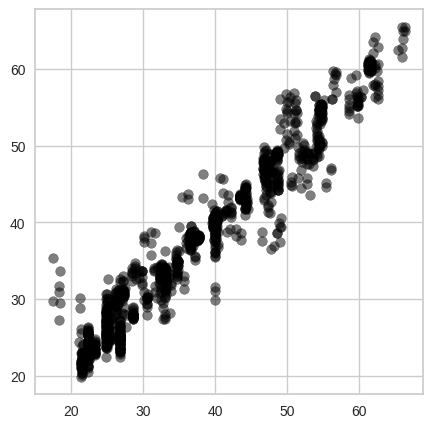

In [ ]:
#support vector regressor
testing = 'Regression'
selection = KFold(shuffle=True)
SVR_sub = []
to_excel =[]
results = []
nested = False

print("Support vector regressor")

# params_svr = {'gamma':[pow(10,i) for i in range(1,-7, -1)], 'C':[pow(10,j) for j in range(-1, 7, 1)]}
# params_svr = {'gamma':[ 100, 10, 1, 0.1, 0.01, 0.001],'C':[0.001, 0.01, 0.1, 1, 10, 100]}
params_svr = {'gamma':[1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001],'C':[0.001, 0.01, 0.1, 1, 10, 100]}
# params_svr = {'gamma': [0.001, 0.0001, 1e-05, 1e-06], 'C': [10, 100, 1000, 10000, 100000]}



best_SVR, SVR_scoring = outer_cross_val(X, Y, selection, SVR(), params_svr, 'Regression')

SVR_score, average_SVR, Y_test, Y_pred, R2_score, average_r2 = SVR_scoring
# SVR_score, average_SVR, SVR_cm, Y_test, Y_pred, _, _, ok1, ok2 = SVR_scoring

Y_pred_q = np.round_(Y_pred, decimals = 0)
print("best score: %.6f" % SVR_score)
print("best R2_score: %.6f" % R2_score)
print("average score: %.6f " % average_SVR)
print("average R2: %.6f " % average_r2)

Support vector regressor
Outer Cross Validation
best_nested_model:  SVR(C=10, gamma=0.0001)
nested_score:  9.561564414261989
nested_r2:  0.1971318853073707
Y_test:  [21.4575 21.5853 21.4192 ... 28.52   29.4044 29.8173]
best_score:  10000
best_nested_model:  SVR(C=10, gamma=0.0001)
nested_score:  8.288410553027438
nested_r2:  0.5578612403238349
Y_test:  [29.0924 28.5118 28.896  ... 33.0873 24.8963 33.0873]
best_score:  9.561564414261989
best_nested_model:  SVR(C=100, gamma=0.0001)
nested_score:  4.75934581789713
nested_r2:  0.6330282896707002
Y_test:  [33.0642 33.0642 39.7394 ... 33.0942 39.928  25.0862]
best_score:  8.288410553027438
best_nested_model:  SVR(C=10, gamma=0.0001)
nested_score:  3.827635175786689
nested_r2:  0.8548719003817074
Y_test:  [33.1025 40.0635 25.042  ... 61.7164 61.3907 61.2567]
best_score:  4.75934581789713
best_nested_model:  SVR(C=100, gamma=0.0001)
nested_score:  97.79599244323224
nested_r2:  -65.51924303537514
Y_test:  [61.4412 61.562  61.6296 ... 21.4796 21

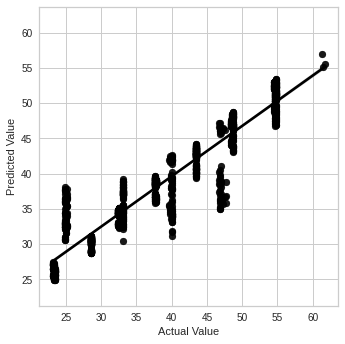

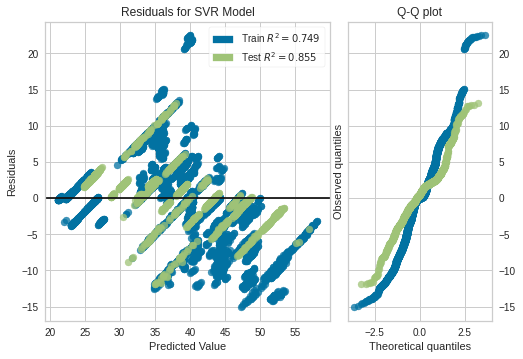

best score: 3.827635
best R2_score: 0.854872
average score: 24.846590 
average R2: -12.655270 


In [ ]:
#support vector regressor
testing = 'Regression'
selection = KFold()
SVR_sub = []
to_excel =[]
results = []
nested = False

print("Support vector regressor")

# params_svr = {'gamma':[pow(10,i) for i in range(1,-7, -1)], 'C':[pow(10,j) for j in range(-1, 7, 1)]}
# params_svr = {'gamma':[ 100, 10, 1, 0.1, 0.01, 0.001],'C':[0.001, 0.01, 0.1, 1, 10, 100]}
params_svr = {'gamma':[1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001],'C':[0.001, 0.01, 0.1, 1, 10, 100]}
# params_svr = {'gamma': [0.001, 0.0001, 1e-05, 1e-06], 'C': [10, 100, 1000, 10000, 100000]}



best_SVR, SVR_scoring = outer_cross_val(X, Y, selection, SVR(), params_svr, 'Regression')

SVR_score, average_SVR, Y_test, Y_pred, R2_score, average_r2 = SVR_scoring
# SVR_score, average_SVR, SVR_cm, Y_test, Y_pred, _, _, ok1, ok2 = SVR_scoring

Y_pred_q = np.round_(Y_pred, decimals = 0)
print("best score: %.6f" % SVR_score)
print("best R2_score: %.6f" % R2_score)
print("average score: %.6f " % average_SVR)
print("average R2: %.6f " % average_r2)

Support vector regressor
Outer Cross Validation
best_nested_model:  SVR(C=100, gamma=0.001)
nested_score:  2.8584834664149072
nested_r2:  0.9400736452307783
Y_test:  [21.4192 21.1579 21.3062 ... 21.4685 21.4794 21.4796]
best_score:  10000
best_nested_model:  SVR(C=100, gamma=0.001)
nested_score:  2.76953460129783
nested_r2:  0.9466365479608179
Y_test:  [21.4192 21.5914 21.6887 ... 21.4685 21.4783 21.4783]
best_score:  2.8584834664149072
best_nested_model:  SVR(C=100, gamma=0.001)
nested_score:  3.014125057221367
nested_r2:  0.9371846528842086
Y_test:  [21.1579 21.6957 21.3213 ... 21.4794 21.4775 21.4796]
best_score:  2.76953460129783
best_nested_model:  SVR(C=100, gamma=0.001)
nested_score:  2.7939213741262656
nested_r2:  0.9462351803168285
Y_test:  [21.6887 21.3062 21.4687 ... 21.4775 21.4783 21.4685]
best_score:  2.76953460129783
best_nested_model:  SVR(C=100, gamma=0.001)
nested_score:  2.8755931297753516
nested_r2:  0.9437719248155594
Y_test:  [21.4575 21.5853 21.165  ... 21.4783 2

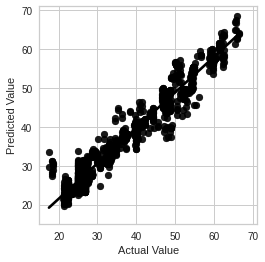

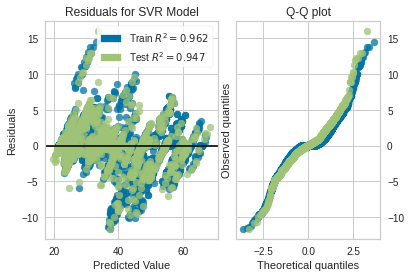

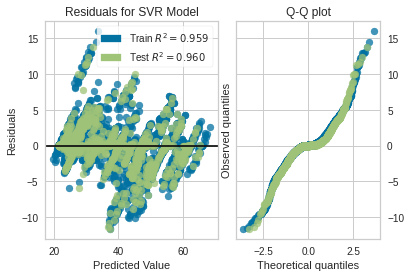

best score: 2.769535
best R2_score: 0.946637
average score: 2.862332 
average R2: 0.942780 


In [ ]:
#support vector regressor
testing = 'Regression'
selection = KFold(shuffle=True)
SVR_sub = []
to_excel =[]
results = []
nested = False

print("Support vector regressor")

# params_svr = {'gamma':[pow(10,i) for i in range(1,-7, -1)], 'C':[pow(10,j) for j in range(-1, 7, 1)]}
# params_svr = {'gamma':[ 100, 10, 1, 0.1, 0.01, 0.001],'C':[0.001, 0.01, 0.1, 1, 10, 100]}
params_svr = {'gamma':[1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001],'C':[0.001, 0.01, 0.1, 1, 10, 100]}
# params_svr = {'gamma': [0.001, 0.0001, 1e-05, 1e-06], 'C': [10, 100, 1000, 10000, 100000]}



best_SVR, SVR_scoring = outer_cross_val(X, Y, selection, SVR(), params_svr, 'Regression')

SVR_score, average_SVR, Y_test, Y_pred, R2_score, average_r2 = SVR_scoring
# SVR_score, average_SVR, SVR_cm, Y_test, Y_pred, _, _, ok1, ok2 = SVR_scoring

Y_pred_q = np.round_(Y_pred, decimals = 0)
print("best score: %.6f" % SVR_score)
print("best R2_score: %.6f" % R2_score)
print("average score: %.6f " % average_SVR)
print("average R2: %.6f " % average_r2)